In [38]:
# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings 
warnings.filterwarnings('ignore')

<h3> Read, clean, and wrangle data </h3>

In [2]:
merged_table = pd.read_csv('merged_table.csv', parse_dates=['invoice_datetime'])

In [3]:
# Convert string 'Null' into null value
merged_table = merged_table.replace({'Null':None})

In [4]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554417 entries, 0 to 554416
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        554417 non-null  object        
 1   product_id        546019 non-null  object        
 2   quantity          554417 non-null  int64         
 3   unit_price        554417 non-null  float64       
 4   total_sale        554417 non-null  float64       
 5   customer_id       415102 non-null  object        
 6   rating            554417 non-null  float64       
 7   review_count      554417 non-null  int64         
 8   country           554417 non-null  object        
 9   product_name      554417 non-null  object        
 10  product_type      554417 non-null  object        
 11  stock_code        554417 non-null  object        
 12  invoice_datetime  554417 non-null  datetime64[ns]
 13  day_of_week       554417 non-null  int64         
 14  mont

In [5]:
# Count number of null values in each column
merged_table.isnull().sum()

invoice_no               0
product_id            8398
quantity                 0
unit_price               0
total_sale               0
customer_id         139315
rating                   0
review_count             0
country                  0
product_name             0
product_type             0
stock_code               0
invoice_datetime         0
day_of_week              0
month                    0
hour                     0
year                     0
quarter                  0
invoice_date             0
dtype: int64

In [6]:
# Dropping rows having missing values
retail = merged_table.dropna()
retail.shape

(409035, 19)

In [7]:
retail.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


In [8]:
retail['max_date'] = max(retail['invoice_datetime'])
retail['max_date'] = pd.to_datetime(retail['max_date'])
retail['recency'] = (retail['max_date'] - retail ['invoice_datetime']).dt.days

In [25]:
retail.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,...,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date,max_date,recency
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,...,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01,2019-12-09 12:00:00,372
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",...,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01,2019-12-09 12:00:00,372


<h5> We want to use three features for k-means clustering: </h5>

- recency: days since last purchase
- frequency: number of orders 
- monetary: 'total_revenue' (per customer_id)

In [13]:
rfm = retail.groupby('customer_id').agg({'invoice_no': 'nunique', 'total_sale':'sum', 'recency': 'min'}).reset_index().rename(columns = {'invoice_no': 'frequency', 'total_sale':'total_rev'})
rfm

,customer_id,frequency,total_rev,recency
0,12346,1,4433604.10,325
1,12347,7,210263.69,1
2,12348,4,174939.60,74
3,12349,1,42183.30,18
4,12350,1,17937.80,309
...,...,...,...,...
4334,18280,1,6720.42,277
4335,18281,1,2713.22,180
4336,18282,2,3304.10,7
4337,18283,16,112986.22,3


<h3> Remove outliers </h3>

Text(0.5, 0, 'Attributes')

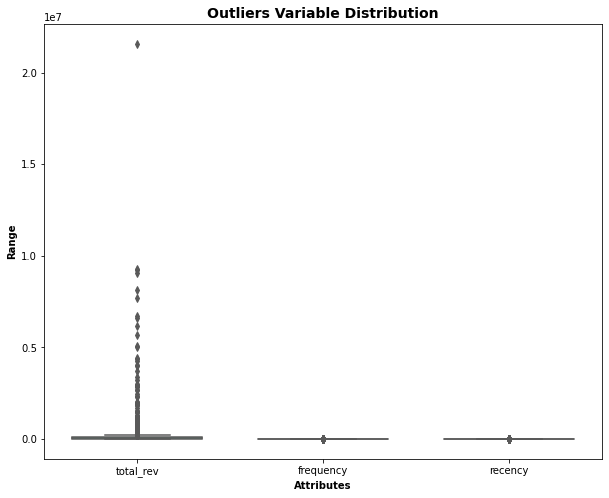

In [10]:
# Outlier Analysis of Amount Frequency and Recency
attributes = ['total_rev','frequency','recency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [14]:
# Remove statistical outliers for each variable

# total_rev
q1 = rfm['total_rev'].quantile(0.05)
q3 = rfm['total_rev'].quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm['total_rev'] >= q1 - 1.5*iqr) & (rfm['total_rev'] <= q3 + 1.5*iqr)]

# frequency
q1 = rfm['frequency'].quantile(0.05)
q3 = rfm['frequency'].quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm['frequency'] >= q1 - 1.5*iqr) & (rfm['frequency'] <= q3 + 1.5*iqr)]

# recency
q1 = rfm['recency'].quantile(0.05)
q3 = rfm['recency'].quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm['recency'] >= q1 - 1.5*iqr) & (rfm['recency'] <= q3 + 1.5*iqr)]

rfm.shape


(4257, 4)

<h3> Scale features </h3>

In [18]:
# Scale the features

rfm_df = rfm[['total_rev', 'frequency', 'recency']]

scaler = StandardScaler()

scaler.fit(rfm_df)
rfm_df_scaled = scaler.transform(rfm_df)

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['total_rev', 'frequency', 'recency']
rfm_df_scaled

,total_rev,frequency,recency
0,1.180403,0.858150,-0.917646
1,0.862194,0.090898,-0.188702
2,-0.333710,-0.676355,-0.747892
3,-0.552120,-0.676355,2.157897
4,-0.081708,1.113901,-0.578138
...,...,...,...
4252,-0.653169,-0.676355,1.838360
4253,-0.689267,-0.676355,0.869764
4254,-0.683944,-0.420604,-0.857733
4255,0.304102,3.159909,-0.897675


<h3> Clustering with 4 clusters </h3>

In [19]:
# k-means clustering with 4 clusters

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [24]:
kmeans.labels_                          # Labels for each data point (customer) (an array)
labels_list = kmeans.labels_            # Save array
sorted(Counter(labels_list).items())    # Retrieve label and count as tuples

[(0, 2299), (1, 1022), (2, 173), (3, 763)]

<h3> Optimise number of clusters </h3>

<h4> 1) Using inertia as the metric (elbow method) </h4>

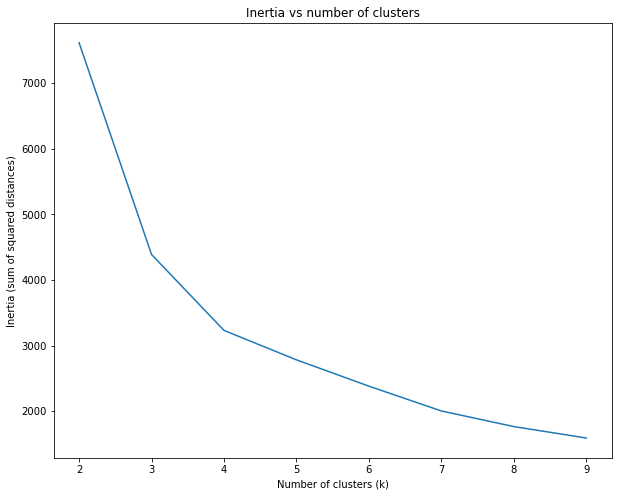

In [35]:
# initialise list of the sum of squared distances (inertia)
ssd = []
k_vals = [2,3,4,5,6,7,8,9]

for k_val in k_vals:
    kmeans = KMeans(n_clusters = k_val, max_iter = 50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

fig, ax = plt.subplots(1,1)
ax.set_title('Inertia vs number of clusters')
ax.plot(ssd)
ax.set_xlabel('Number of clusters (k)')
ax.set_xticks(ticks = list(range(len(k_vals))))
ax.set_xticklabels(labels = k_vals)
ax.set_ylabel ('Inertia (sum of squared distances)')
plt.show()

<h4> 2) Using silhouette score as metric </h3>

- Tutorial for creating silhouette plots:
- https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

In [36]:
k_vals = [2,3,4,5,6,7,8,9]

for k_val in k_vals:
    kmeans = KMeans(n_clusters = k_val, max_iter = 50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print(f'For {k_val} clusters, silhouette score is {silhouette_avg}')

For 2 clusters, silhouette score is 0.5254872458545418
For 3 clusters, silhouette score is 0.5008251417548556
For 4 clusters, silhouette score is 0.4823844816821499
For 5 clusters, silhouette score is 0.4445841466023941
For 6 clusters, silhouette score is 0.4049416620918626
For 7 clusters, silhouette score is 0.4071225335889719
For 8 clusters, silhouette score is 0.40213020783370634
For 9 clusters, silhouette score is 0.3752721204564782


<h3> 3) Create silhouette plot <h3>

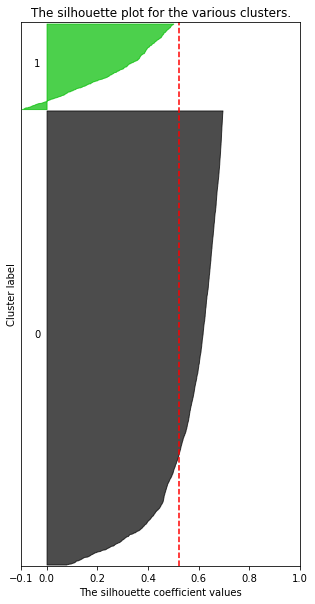

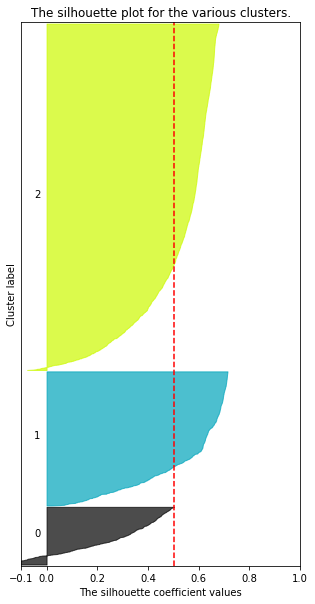

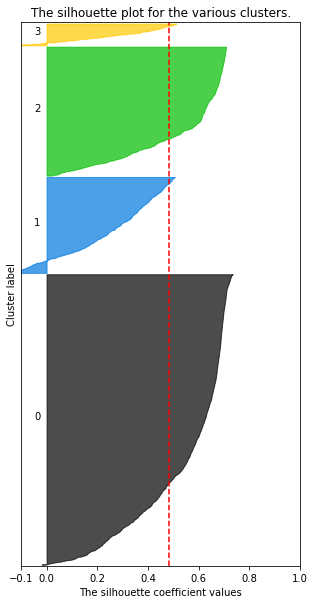

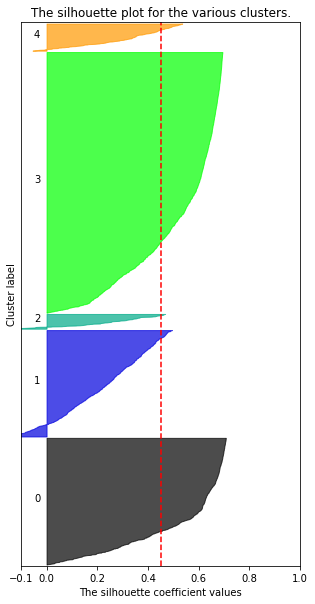

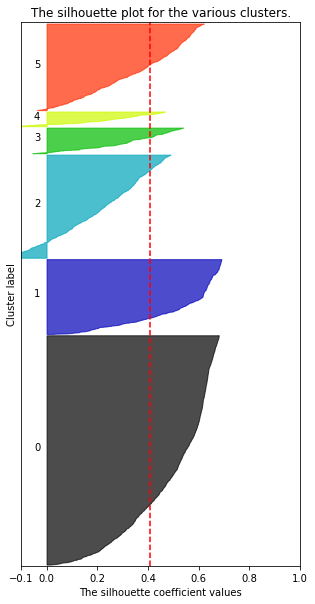

In [44]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(1,1, figsize = (5,10))

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(rfm_df_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters = n_clusters)
    cluster_labels = clusterer.fit_predict(rfm_df_scaled)

    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)

    # Compute silhouette score for each sample
    sample_silhouette_values = silhouette_samples(rfm_df_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]           # Check how the indexing in silhouette_samples works
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        


- Frankly all of these look quite terrible

<h3> Using just two features </h3>

- We saw that the clustering worked very poorly when we used the features "total_rev", "frequency", "rev"
- Now try using just "total_rev" and "frequency"
- This way, we can also create scatter plots and see if there are indeed clusters

In [45]:
rfm = retail.groupby('customer_id').agg({'invoice_no': 'nunique', 'total_sale':'sum'}).reset_index().rename(columns = {'invoice_no': 'frequency', 'total_sale':'total_rev'})
rfm

,customer_id,frequency,total_rev
0,12346,1,4433604.10
1,12347,7,210263.69
2,12348,4,174939.60
3,12349,1,42183.30
4,12350,1,17937.80
...,...,...,...
4334,18280,1,6720.42
4335,18281,1,2713.22
4336,18282,2,3304.10
4337,18283,16,112986.22


Text(0.5, 0, 'Attributes')

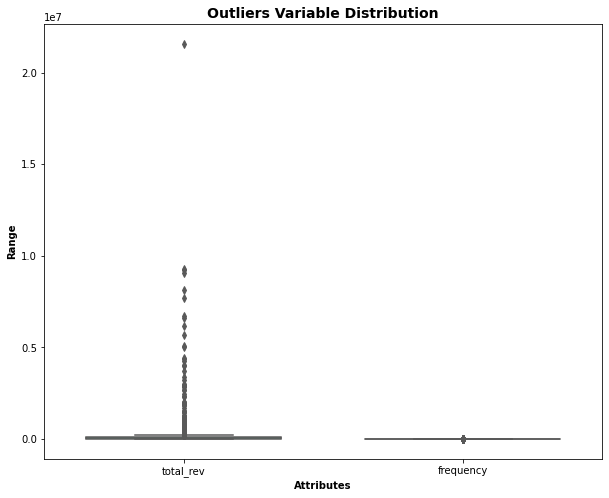

In [46]:
# Outlier Analysis of Amount Frequency and Recency
attributes = ['total_rev','frequency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [47]:
# Remove statistical outliers for each variable

# total_rev
q1 = rfm['total_rev'].quantile(0.05)
q3 = rfm['total_rev'].quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm['total_rev'] >= q1 - 1.5*iqr) & (rfm['total_rev'] <= q3 + 1.5*iqr)]

# frequency
q1 = rfm['frequency'].quantile(0.05)
q3 = rfm['frequency'].quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm['frequency'] >= q1 - 1.5*iqr) & (rfm['frequency'] <= q3 + 1.5*iqr)]


rfm.shape


(4257, 3)

In [49]:
# Scale the features

rfm_df = rfm[['total_rev', 'frequency']]

scaler = StandardScaler()

scaler.fit(rfm_df)
rfm_df_scaled = scaler.transform(rfm_df)

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['total_rev', 'frequency']
rfm_df_scaled

,total_rev,frequency
0,1.180403,0.858150
1,0.862194,0.090898
2,-0.333710,-0.676355
3,-0.552120,-0.676355
4,-0.081708,1.113901
...,...,...
4252,-0.653169,-0.676355
4253,-0.689267,-0.676355
4254,-0.683944,-0.420604
4255,0.304102,3.159909


<h4> Using inertia as the metric (elbow method) </h4>

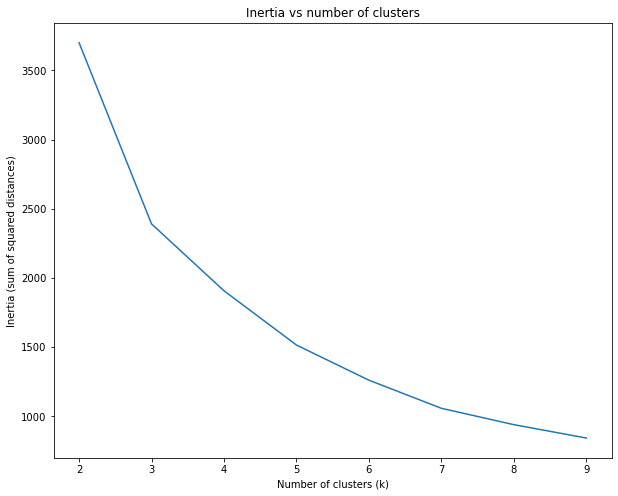

In [50]:
# initialise list of the sum of squared distances (inertia)
ssd = []
k_vals = [2,3,4,5,6,7,8,9]

for k_val in k_vals:
    kmeans = KMeans(n_clusters = k_val, max_iter = 50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

fig, ax = plt.subplots(1,1)
ax.set_title('Inertia vs number of clusters')
ax.plot(ssd)
ax.set_xlabel('Number of clusters (k)')
ax.set_xticks(ticks = list(range(len(k_vals))))
ax.set_xticklabels(labels = k_vals)
ax.set_ylabel ('Inertia (sum of squared distances)')
plt.show()

In [51]:
rfm_df_scaled

,total_rev,frequency
0,1.180403,0.858150
1,0.862194,0.090898
2,-0.333710,-0.676355
3,-0.552120,-0.676355
4,-0.081708,1.113901
...,...,...
4252,-0.653169,-0.676355
4253,-0.689267,-0.676355
4254,-0.683944,-0.420604
4255,0.304102,3.159909


<AxesSubplot:xlabel='total_rev', ylabel='frequency'>

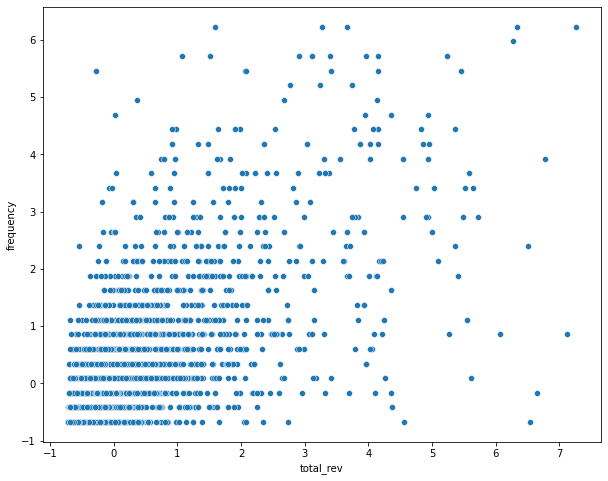

In [53]:
sns.scatterplot(x = rfm_df_scaled['total_rev'], y = rfm_df_scaled['frequency'])

In [61]:
rfm_df_scaled.iloc[:,0]

0       1.180403
1       0.862194
2      -0.333710
3      -0.552120
4      -0.081708
          ...   
4252   -0.653169
4253   -0.689267
4254   -0.683944
4255    0.304102
4256    0.365829
Name: total_rev, Length: 4257, dtype: float64

For n_clusters = 2 The average silhouette_score is : 0.7041449496469252
For n_clusters = 3 The average silhouette_score is : 0.6032484503549403
For n_clusters = 4 The average silhouette_score is : 0.5414982352619635
For n_clusters = 5 The average silhouette_score is : 0.548925546476605
For n_clusters = 6 The average silhouette_score is : 0.5168254793030289
For n_clusters = 7 The average silhouette_score is : 0.4922746265219153
For n_clusters = 8 The average silhouette_score is : 0.4855051407346799
For n_clusters = 9 The average silhouette_score is : 0.4837709210217575
For n_clusters = 10 The average silhouette_score is : 0.482710470635444


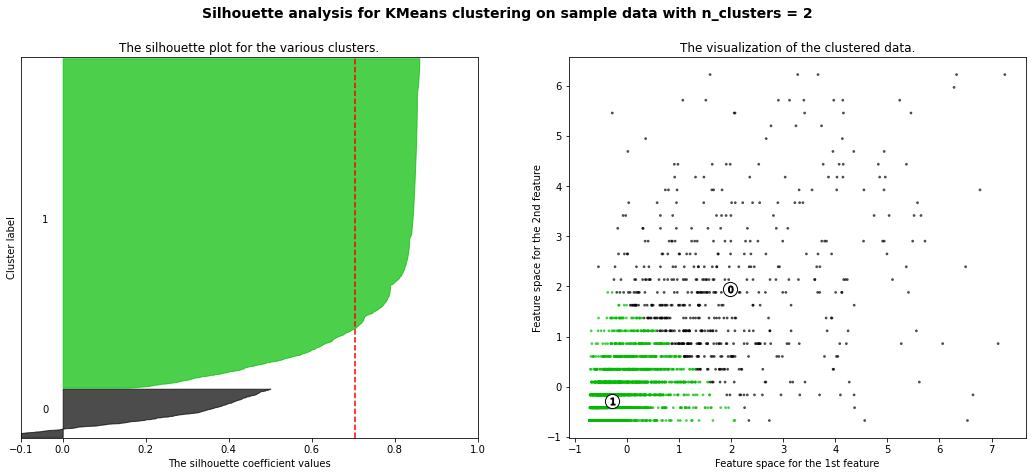

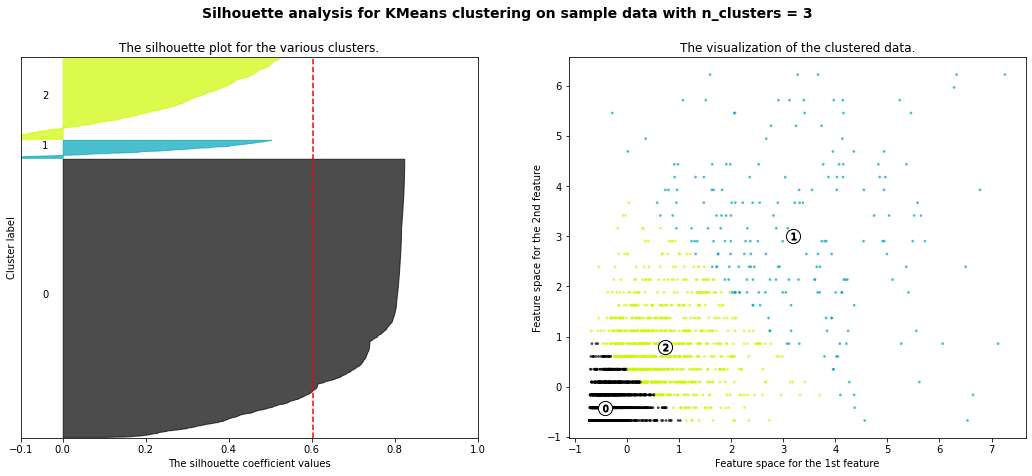

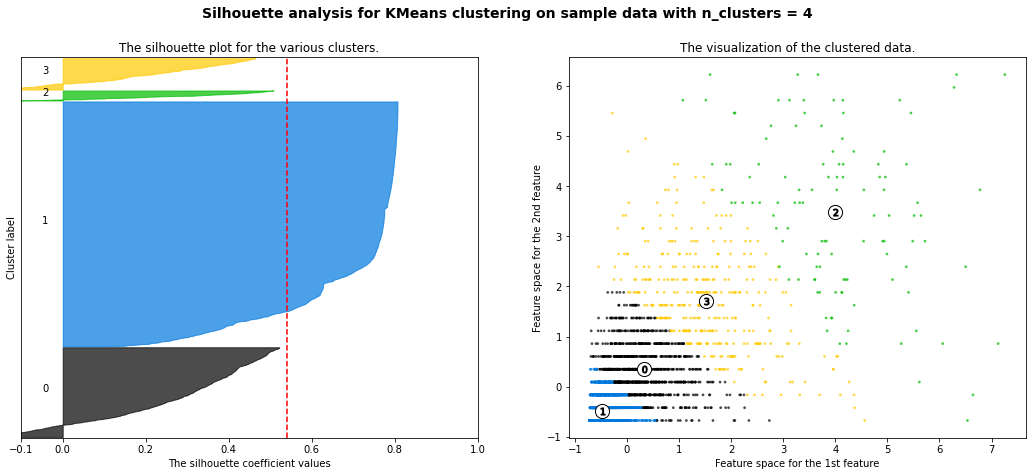

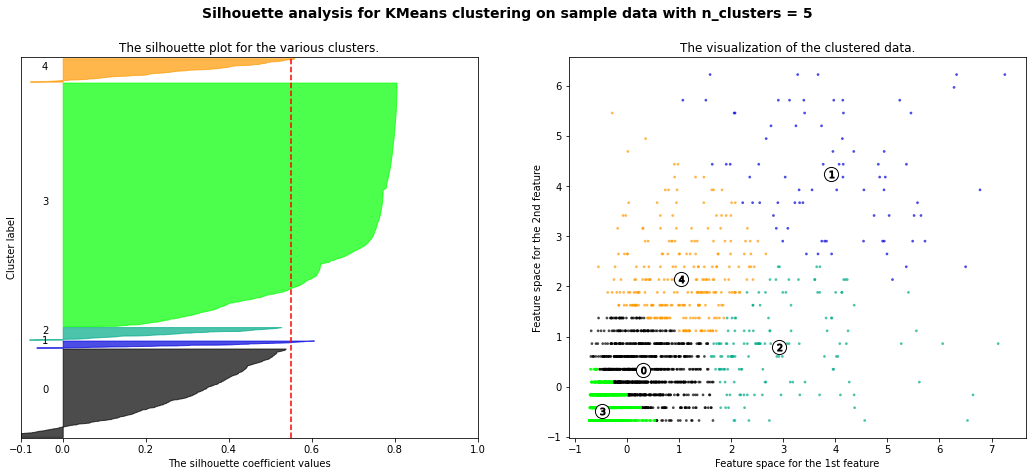

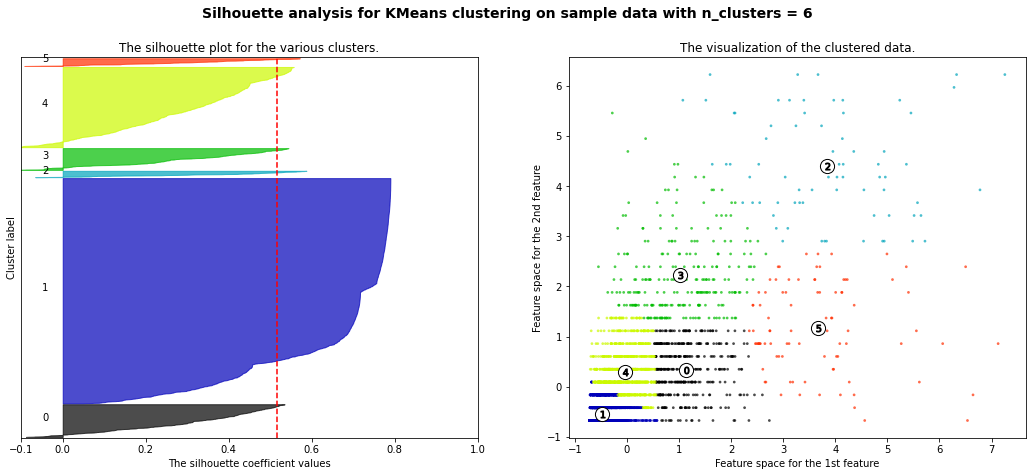

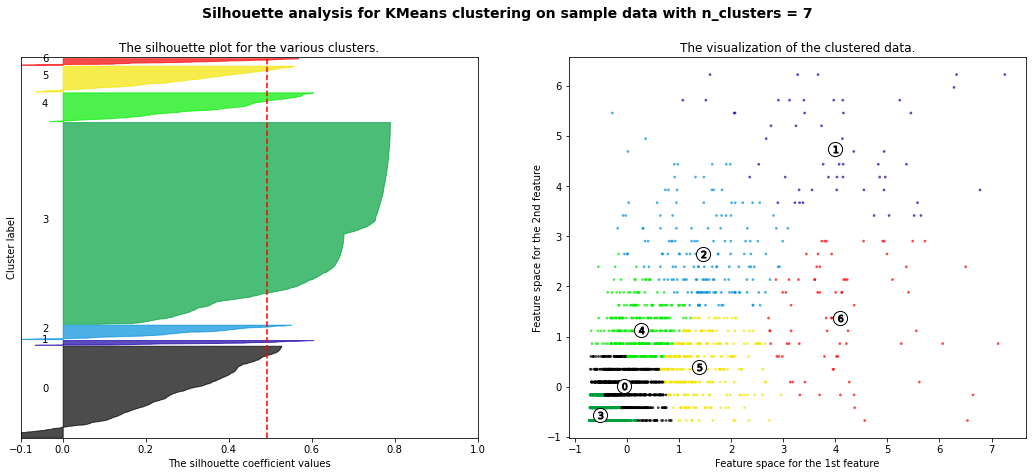

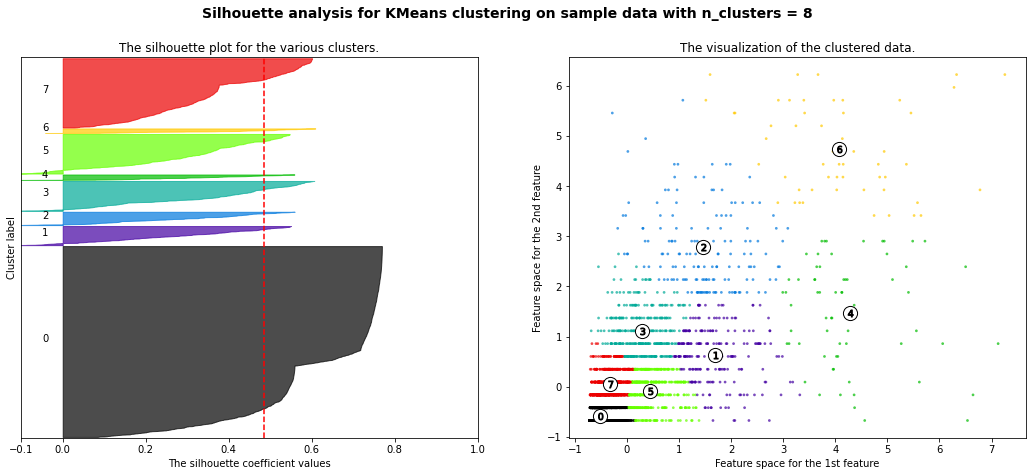

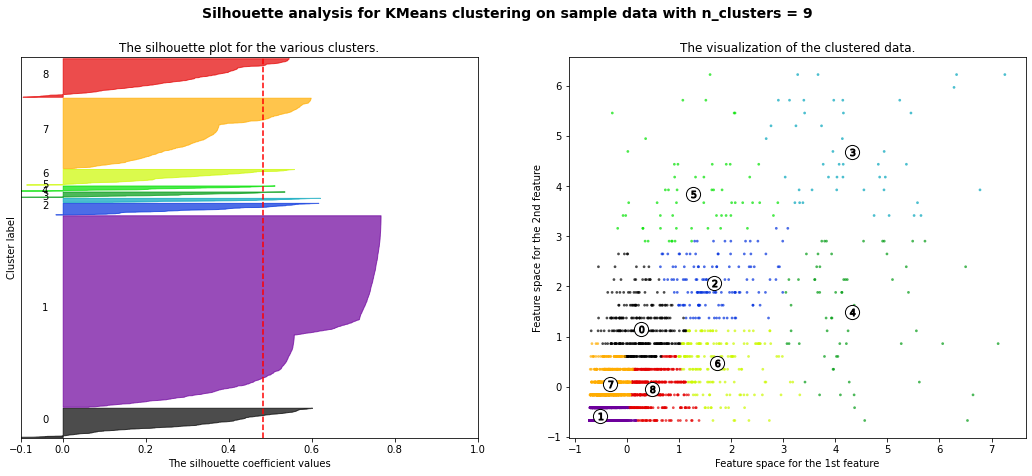

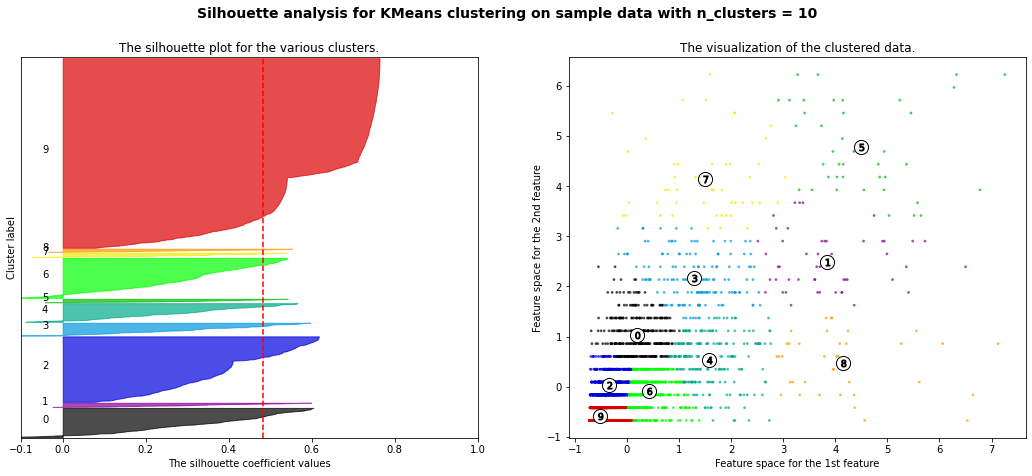

In [64]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_df_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(rfm_df_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_df_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_df_scaled.iloc[:,0], rfm_df_scaled.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()



- OK, as suspected, the dataset being synthesised means no meaningful clustering happens